In [10]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import string

# TO-DO:
<s>1) Fix column names in grid mix dataframe</s>

<s> 1.1) Add CO2e calculation, vehicle assembly, battery assembly </s> 

<s> 2) Figure out how to account for PHEV emissions (relevant papers?)</s> 

<s>3) Figure out how to account for HEV battery, if necessary</s> 

<s>4) Figure out how to distinguish NIMH/LI battery data </s>

5) Clean up vehicle_type vs vehicle_class

<s> 6) Integrate zip-code choice </s>

<s>  7) Integrate into django Model ORM </s> 

In [288]:
## create combined vehicle emissions:

## join curb_weight_join to weighted total c02 emissions by vehicle
## need to get embodied emissions and in-use emissions 
## embodied_emissions = vehicleCo2_vector*vehicle_C02_weightings*mass_vehicle
## in-use emissions = Co2/mile = mpg(e)*carbon_intensity
## carbon intensity = carbon intensity of fuel or carbon intensity of grid_mix 
## grid_mix carbon_intensitty = c02 emissions at entered zip code or take average of all zip codes
## append in-use emissions, embodied emissions, and total emissions (embodied+in_use) to joined vehicle data

In [11]:
## load in data
## need vehicle data, emissions weightings/intensities by vehicle, zip data
vehicle_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/adj_weight_data_join.csv")
subregion_emissions = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/subregion_emissions.csv")

## embodied emissions data (includes both weightings and intensities in the same table)
LI_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_LI.csv")
NIMH_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_NIMH.csv")
vehicle_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_vehicle.csv")

In [12]:
## make sure emissions column names are formatted properly
LI_emissions_data.columns = [i.strip(" ,") for i in LI_emissions_data.columns]
NIMH_emissions_data.columns = [i.strip(" ,") for i in NIMH_emissions_data.columns]
vehicle_emissions_data.columns = [i.strip(" ,") for i in vehicle_emissions_data.columns]

In [13]:
## save csvs with formatted column names
## embodied emissions data (includes both weightings and intensities in the same table)
LI_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_LI.csv", index = False)
NIMH_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_NIMH.csv", index = False)
vehicle_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_vehicle.csv", index = False)

In [14]:
vehicle_data[vehicle_data['atvType'] == 'HEV']

,Model_y,Make_y,Year,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,combinedUF,combE,highway08U,rangeHwyA,RangeHwy,Range,city08U,UCity,UHighway
4,Discovery MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45104,5250.000000,22.0,0.0,0.0,25.2170,0.0,0.0,0.0,19.4394,24.4829,35.5392
6,Defender 110 MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45106,5675.000000,20.0,0.0,0.0,22.6469,0.0,0.0,0.0,18.2647,22.9121,31.5521
7,Defender 90 MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45107,5675.000000,20.0,0.0,0.0,22.6469,0.0,0.0,0.0,18.2647,22.9121,31.5521
24,Sportage Hybrid AWD,Kia,2023,HEV,4.0,1.6,Automatic (AM-S6),45207,4119.444444,38.0,0.0,0.0,37.9799,0.0,0.0,0.0,38.2202,52.1815,49.9036
25,Sportage Hybrid FWD,Kia,2023,HEV,4.0,1.6,Automatic (AM-S6),45208,4119.444444,43.0,0.0,0.0,44.3121,0.0,0.0,0.0,42.2521,57.7000,55.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,Alpina XB7,BMW,2023,HEV,8.0,4.4,Automatic (S8),46156,5500.000000,17.0,0.0,0.0,20.2334,0.0,0.0,0.0,15.5008,19.2000,28.0000
643,Highlander Hybrid AWD LTD/PLAT,Toyota,2023,HEV,4.0,2.5,Automatic (AV-S6),46157,4750.000000,35.0,0.0,0.0,34.0000,0.0,0.0,0.0,35.4652,48.2000,47.0000
644,Highlander Hybrid AWD,Toyota,2023,HEV,4.0,2.5,Automatic (AV-S6),46158,4750.000000,35.0,0.0,0.0,34.7889,0.0,0.0,0.0,35.1424,47.6000,46.4000
649,F150 Pickup 2WD HEV,Ford,2023,HEV,6.0,3.5,Automatic (S10),46166,5693.640351,25.0,0.0,0.0,25.1517,0.0,0.0,0.0,25.1342,32.5000,35.4000


In [15]:
## first average subregion emissions (use CO2e)
## in this table, values are in lbs/MWh
avg_CO2eRate = subregion_emissions['CO2eRate'].mean()
## convert from lbs/MWh to g/kWh
avg_CO2eRate = avg_CO2eRate*453.592/1000

In [164]:
## define functions to import as a file
## Vehicle is planned object which will be one entry taken from EPA vehicle testing database
## User is planned object which will store a user's input

def est_battery_capacity_from_vehicle(Vehicle):
    '''return battery capacity in kwh'''
    kwh_size = 0
    if Vehicle.atvType == 'EV':
        kwh_size = Vehicle.Range*(1/Vehicle.highway08U)*33.7 ## use Range since all EVs have it
    elif Vehicle.atvType == 'PHEV':
        kwh_size = Vehicle.rangeHwyA*(Vehicle.combE/100) ## range*(kWh/100 miles) = kWh estimated
#     print(kwh_size)
    return kwh_size

def get_HEV_battery_weight(vehicle_weight, vehicle_year):
    if vehicle_year < 2020: ## for vehicles before 2020, assume NIMH, after assume Li-ion (lighter weight)
        weight_factor = 1
    else:
        weight_factor = 0.485 ## From GREET 2 NIMH/LI-ion battery weight estimates
    ## simple clustering by vehicle weight 
    ## estimated from HEV battery replacement data at https://www.besthybridbatteries.com
    ## adjust by weight factor 2020 model year and after
    if vehicle_weight < 3300: 
        return 75*weight_factor
    elif vehicle_weight > 3300 and vehicle_weight < 4000:
        return 120*weight_factor
    else:
        return 150*weight_factor
    
def est_battery_weight_from_vehicle(Vehicle):
    ''' return battery weight in lbs'''
    if Vehicle.atvType == 'HEV':
        return get_HEV_battery_weight(Vehicle.AdjWeight, Vehicle.Year)
    else:
        return est_battery_capacity_from_vehicle(Vehicle)*1/(.2)*2.204 ## assume 0.2 kWh/Kg energy density

def est_battery_assembly_emissions(Vehicle, emittant):
    battery_assembly_dict = {'VOC': 2.24, 'CO': 9.129,'NOx': 13.081,'PM10': 0.939,
     'PM2.5': 0.747,'SOx': 3.981,'BC': 0.099,'OC': 0.279,'CH4': 37.428,'N2O': 0.361,
     'CO2': 12374}
    return est_battery_capacity_from_vehicle(Vehicle)*battery_assembly_dict[str(emittant)]

def weighted_emissions_calc(vehicle_weight, mass_fractions, emissions_vector):
    mass_fractions = np.array(mass_fractions)
    emissions_vector = np.array(emissions_vector)
    return np.sum(vehicle_weight*mass_fractions*emissions_vector)

H2w = [0.77, 0.165, 0.165] ## from CA standard: 33% 'renewable',assumed as 50/50 green elecrtrolysis/biomethane
## gCo2e/MJ https://ww2.arb.ca.gov/sites/default/files/classic/fuels/lcfs/ca-greet/lut-doc.pdf
H2CO2e = [117.67, 99.48, 10.51] 
def get_FCV_usage_emissions(vehicle_efficiency, miles_estimated, 
                                hydrogen_weights=H2w, emissions_vector_hydrogen=H2CO2e):
    '''assumes vehicle efficiency entered in mpge'''
    ## model as efficiency*distance*emissions_intensity
    ## emissions_intensity is weighted sum of emissions intensities
    total_intensity = np.sum(np.array(hydrogen_mix)*np.array(emissions_vector))
    ## mpg ~ m/kgH2
    ## 120 MJ/kg H2 (energy.gov)
    usage_emissions = (vehicle_efficiency**-1)*miles_estimated*total_intensity*120
    return usage_emissions
    
    
def get_HEV_battery_emissions(battery_weight, NIMH_emissions_manufacturing, 
                             LI_emissions_manufacturing, emissions_type, vehicle_type):
    if battery_weight > 75: ## then it is a NIMH battery based on grouping and scaling factor
        return weighted_emissions_calc(battery_weight, NIMH_emissions_manufacturing[str(emissions_type)], 
                                       NIMH_emissions_manufacturing[str(vehicle_type)])
    else:
        return weighted_emissions_calc(battery_weight, 
                                       LI_emissions_manufacturing[str(emissions_type)], 
                                       LI_emissions_manufacturing[str(vehicle_type)])
    
def get_fuel_carbon():
    ## future option: 
    #     np.sum(total_fuel*(np.array(fuel_import_region_weights)*np.array(upstream_ghg_intensities)))
    ##
    carbon_per_MJ = 90.5432 ## gCO2e/MJ from GREET WTW calculator US average
    energy_per_gallon = 118227 ## BTU/gallon averaged from https://afdc.energy.gov/files/u/publication/fuel_comparison_chart.pdf
    ## now convert from carbon per MJ to carbon per gallon (.001055 btu per MJ)
    return carbon_per_MJ*energy_per_gallon*.001055  ## from GREET WTW calculator, GREET1 model with US fuel mix

def get_PHEV_usage_emissions(Vehicle, miles_estimated, grid_intensity):
    '''implement PHEV emissions calculation using EPA utility factor'''
    utility_factor = Vehicle.combinedUF
    electric_eff = Vehicle.combE ## in kwh/100 miles (average energy consumption in both hybrid and EV modes)
    permile_electric_eff = electric_eff/100
    combined_mpge = Vehicle.comb08
    
    grid_carbon = grid_intensity*permile_electric_eff*miles_estimated 
    fuel_carbon = (combined_mpge**-1)*miles_estimated*get_fuel_carbon() ## consumption in hybrid mode (EV mode is zero fuel)
    
    
    return 1/((1/grid_carbon) + (1-utility_factor)/fuel_carbon) ## electric_eff always applies (no weight)   
    
##
## update to also work with lightweight versions correctly?
##
def get_embodied_emissions(vehicle_weight, battery_weight, vehicle_type, 
                           emissions_type, vehicle_emissions_manufacturing, 
                           LI_emissions_manufacturing, NIMH_emissions_manufacturing):
    vehi_sum = weighted_emissions_calc(vehicle_weight, vehicle_emissions_manufacturing[str(emissions_type)], 
                                       vehicle_emissions_manufacturing[str(vehicle_type)])
    if vehicle_type == 'ICEV: Conventional Material':
        battery_sum = 0
        fluids = 634200
    elif vehicle_type == 'HEV: Conventional Material':
        battery_sum = get_HEV_battery_emissions(battery_weight, 
                                                NIMH_emissions_manufacturing,
                                                LI_emissions_manufacturing, emissions_type, vehicle_type)
        fluids = 634200
    elif vehicle_type == 'PHEV: Conventional Material':
        battery_sum = weighted_emissions_calc(battery_weight, LI_emissions_manufacturing[str(emissions_type)], 
                                       LI_emissions_manufacturing[str(vehicle_type)]) 
        fluids = 571000
    elif vehicle_type == 'FCV: Conventional Material':
        battery_sum = 400000 ## assume 1.5 kWh Li-ion battery ~100 lbs (reasonable based on Mirai battery)
        fluids = 167000
    else:
        battery_sum = weighted_emissions_calc(battery_weight, LI_emissions_manufacturing[str(emissions_type)], 
                                              LI_emissions_manufacturing[str(vehicle_type)])
        fluids = 82000
        
    if emissions_type == 'CO2':
        ## terms assumed constant:
        lead_acid_battery = 60000
        vehicle_adr = 874000
        battery_sum+=lead_acid_battery
        return battery_sum, vehi_sum, (vehi_sum + battery_sum + fluids + vehicle_adr)
    else: ## assume for other emittants the constant terms are negible (don't add them)
        return battery_sum, vehi_sum, (vehi_sum + battery_sum)
        

# def est_embodied_emissions(Vehicle):
#     ## account for EV battery or ICE
#     if Vehicle.battery == True:
#         battery = True
#         kwh_size = est_battery_capacity_from_vehicle(Vehicle)
#     else:
#         battery = False
#         kwh_size = 0
#     vehicle_weight = Vehicle.weight
#     ## send estimated battery capacity and vehicle weight to embodied emissions function
#     embodied_emissions = get_embodied_emissions(vehicle_weight, battery_weight)  
#     return embodied_emissions

# def get_grid_carbon(user_zip, Zip, Co2):
#     ## store lookup table of CO2 intensity by grid region
#     ## convert User zipcode input to grid region
# #     user_region = Zip[Zip['ZIP'] == user_zip]
# #     Co2 = Co2[Co2['Co2'] == user_region]
#     return Co2
    

def get_usage_emissions(Vehicle, vehicle_fuel_economy, vehicle_class, 
                        miles_estimated, grid_intensity = avg_CO2eRate):

    if vehicle_class == 'ICE' or vehicle_class == 'HEV':
        return (vehicle_fuel_economy**-1)*miles_estimated*get_fuel_carbon() ## (g/mile*miles*gCo2/gallon)
    elif vehicle_class == 'EV':
        grid_carbon = grid_intensity*((vehicle_fuel_economy/33.7)**-1)*miles_estimated ## convert mpge to kwh/mile, return gC
        return grid_carbon ## carbon per kwh*kwh/gallon
    elif vehicle_class == 'PHEV': ## assume vehicle is driven in combined cycle (battery and engine)
        return get_PHEV_usage_emissions(Vehicle, miles_estimated, grid_intensity) 
    elif vehicle_class == 'FCV':
        return get_FCV_usage_emissions(vehicle_fuel_economy, miles_estimated, 
                                       hydrogen_weights=H2w, emissions_vector_hydrogen=H2CO2e)
    else:
        return 0

# def est_lifetime_emissions(Vehicle, User):
#     ## account for EV battery or ICE
#     embodied_emissions = est_embodied_emisions(Vehicle)
#     usage_emissions = est_usage_emissions(Vehicle,User)
#     return embodied_emissions+usage_emissions

def conv_or_lw(vehicle_class, lightweight=False):
    '''input vehicle_class (Vehicle.atvType) and Boolean (lightweight = False for conventional)'''
    
    possible_columns = ['ICEV: Conventional Material', 'ICEV: Lightweight Material',
       'HEV: Conventional Material', 'HEV: Lightweight Material',
       'PHEV: Conventional Material', 'PHEV: Lightweight Material',
       'EV: Conventional Material', 'EV: Lightweight Material',
       'FCV: Conventional Material', 'FCV: Lightweight Material']
    
    if not lightweight:
        if vehicle_class == 'ICE':
            return possible_columns[0]
        elif vehicle_class == 'HEV':
            return possible_columns[2]
        elif vehicle_class == 'PHEV':
            return possible_columns[4]
        elif vehicle_class == 'EV':
            return possible_columns[6]
        else:
            return possible_columns[8]
    elif lightweight:
        if vehicle_class == 'ICE':
            return possible_columns[1]
        elif vehicle_class == 'HEV':
            return possible_columns[3]
        elif vehicle_class == 'PHEV':
            return possible_columns[5]
        elif vehicle_class == 'EV':
            return possible_columns[7]
        else:
            return possible_columns[9]
    else:
        print("there was an error with get_emissions_weights lightweight parameter")
        return
        
        

emittant_dictionary = {'CO2':1, 'CH4':25, 'N2O':298} ## from IPCC report (wikipedia/GWP)
def get_CO2e(value, emittant, conversions=emittant_dictionary):
    '''given a GHG emittant and a emissions value, return CO2e.
    Use global warming potential at 100 years as a scaling factor'''
#     print(value)
    return value*conversions[emittant]
    
        
def process_vehicle(Vehicle, Manufacturing, LI_Battery, NIMH_Battery, emissions_types):
    vehicle_fuel_economy = Vehicle.highway08U*.55 + Vehicle.city08U*.45 ## combined fuel economy (EPA.gov)
    vehicle_weight = Vehicle.AdjWeight
    vehicle_class = Vehicle.atvType
    vehicle_year = Vehicle.Year
    vehicle_type = conv_or_lw(vehicle_class)
    battery_weight = est_battery_weight_from_vehicle(Vehicle)
    
    lifetime_emissions = []
    embodied_emissions = {"battery_assembly":0, "battery":0, "vehicle_assembly":0, "total_embodied":0}
    for emittant in emissions_types:
        
        ## get battery, vehicle, and battery and vehicle emissions associated with a given emittant
        battery, vehicle, total = get_embodied_emissions(vehicle_weight, battery_weight, vehicle_type, 
                           emittant, Manufacturing, 
                           LI_Battery, NIMH_Battery)
        ## get battery assembly emisions 
        batt_assembly = est_battery_assembly_emissions(Vehicle, emittant)
        
        ## add emissions for each emittant to totals
        ## convert each emittant to CO2e
        embodied_emissions["battery_assembly"]+=get_CO2e(batt_assembly, emittant)
        embodied_emissions["battery"]+=get_CO2e(battery, emittant)
        embodied_emissions["vehicle_assembly"]+=get_CO2e(vehicle, emittant)
        embodied_emissions["total_embodied"]+=get_CO2e(total, emittant)
        embodied_emissions["total_embodied"]+=get_CO2e(batt_assembly, emittant)
    ## for ICE vehicles, get_fuel_carbon calculates CO2e, including upstream CO2e
    ## for grid mix, select CO2e option
    batt_assembly, battery, vehicle, total_embodied = list(embodied_emissions.values())
    usage = get_usage_emissions(Vehicle, vehicle_fuel_economy, vehicle_class, miles_estimated=178000)
    lifetime_emissions.append([batt_assembly, battery, vehicle, total_embodied, usage, (total_embodied + usage)])
    return lifetime_emissions

    

In [58]:
## Approach: since here we aren't taking a specific zip code, average C02 emissions across all zip codes
## then for a given vehicle type calculate in-use emissions according to efficiency*carbon_intensity
## for ICE vehicles, use mpge*cabon_intensity_petrol
## for EVs, use average grid mix intensity
## for PHEVs, use mpge*carbon_intensity_petrol, assume combined cycle driving

In [59]:
## CO2e calculation
## for CO2e we use CO2, CH4, N2O
emissions_array = []
for i in range(len(vehicle_data)):
    Vehicle = vehicle_data.iloc[i]
    lifetime_emissions = process_vehicle(Vehicle, vehicle_emissions_data, LI_emissions_data, NIMH_emissions_data, ['CO2', 'CH4', 'N2O'])
    emissions_array.append(lifetime_emissions)
emissions_array = np.array(emissions_array).squeeze()

In [60]:
## mean with CO2 only
np.mean(emissions_array, axis = 0)

array([  114268.45069552,   502096.27233733,  7244758.44277839,
        9312132.37083215, 79589465.04350981, 88901597.41434178])

In [61]:
## mean with CO2e 
## (usage emissions doesn't change since grid mix assumes CO2e already and gas emissions assume CO2e~CO2)
np.mean(emissions_array, axis = 0)

array([  114268.45069552,   502096.27233733,  7244758.44277839,
        9312132.37083215, 79589465.04350981, 88901597.41434178])

In [62]:
emissionsdf = pd.DataFrame(emissions_array)

In [63]:
emissionsdf.columns = ['battery_assembly', 'battery_manufacture', 
                       'vehicle_manufacture', 'total_embodied', 'usage', 'total']

In [64]:
emissionsjoin = pd.merge(vehicle_data, emissionsdf, left_index = True, right_index = True)

In [65]:
emissionsjoin

,Model_y,Make_y,Year,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,...,Range,city08U,UCity,UHighway,battery_assembly,battery_manufacture,vehicle_manufacture,total_embodied,usage,total
0,Defender 90,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45099,5675.000000,19.0,...,0.0,17.8574,22.3491,30.5805,0.0,60000.000000,8.928648e+06,1.049685e+07,1.033396e+08,1.138365e+08
1,Sportage FWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45101,4119.444444,28.0,...,0.0,24.8603,32.1057,45.6871,0.0,60000.000000,6.481246e+06,8.049446e+06,7.020522e+07,7.825466e+07
2,Sportage AWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45102,4119.444444,25.0,...,0.0,22.6477,28.9565,40.4900,0.0,60000.000000,6.481246e+06,8.049446e+06,7.781498e+07,8.586443e+07
3,Discovery,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45103,5250.000000,21.0,...,0.0,19.3318,24.3528,33.7329,0.0,60000.000000,8.259983e+06,9.828183e+06,9.603214e+07,1.058603e+08
4,Discovery MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45104,5250.000000,22.0,...,0.0,19.4394,24.4829,35.5392,0.0,333499.846543,7.368220e+06,9.209919e+06,8.888090e+07,9.809082e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,RC F,Lexus,2023,ICE,8.0,5.0,Automatic (S8),46350,4125.000000,19.0,...,0.0,16.3887,20.4000,33.3000,0.0,60000.000000,6.489987e+06,8.058187e+06,9.659530e+07,1.046535e+08
713,Tucson FWD,Hyundai,2023,ICE,4.0,2.5,Automatic (S8),46375,4105.555556,28.0,...,0.0,24.9271,32.2017,45.8896,0.0,60000.000000,6.459394e+06,8.027594e+06,6.996204e+07,7.798964e+07
714,Bronco Sport 4WD,Ford,2023,ICE,3.0,1.5,Automatic 8-spd,46385,5665.178571,26.0,...,0.0,25.3012,32.7408,43.3816,0.0,60000.000000,8.913196e+06,1.048140e+07,7.504894e+07,8.553034e+07
715,Bronco Sport 4WD,Ford,2023,ICE,4.0,2.0,Automatic (S8),46386,5665.178571,23.0,...,0.0,21.1067,26.8000,39.2000,0.0,60000.000000,8.913196e+06,1.048140e+07,8.447034e+07,9.495173e+07


array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

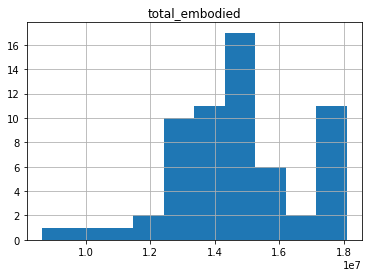

In [66]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'EV'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

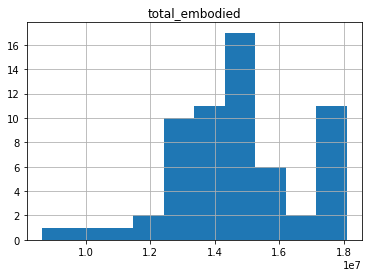

In [344]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'EV'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

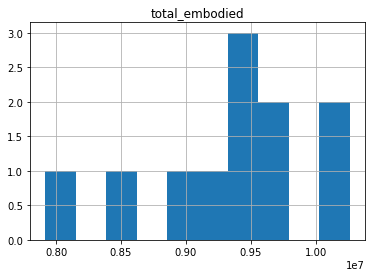

In [345]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'PHEV'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

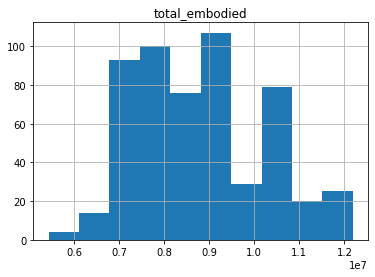

In [346]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'ICE'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

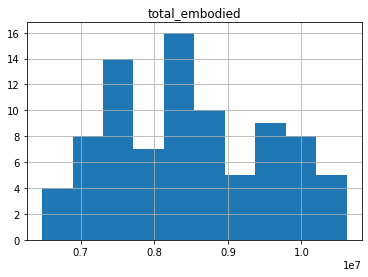

In [67]:
## new HEV battery emissions
emissionsjoin[emissionsjoin['atvType'] == 'HEV'].hist('total_embodied') 

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

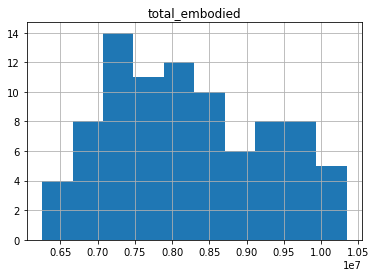

In [347]:
## some simple checks
## No HEV battery emissions
#emissionsjoin[emissionsjoin['atvType'] == 'HEV'].hist('total_embodied')

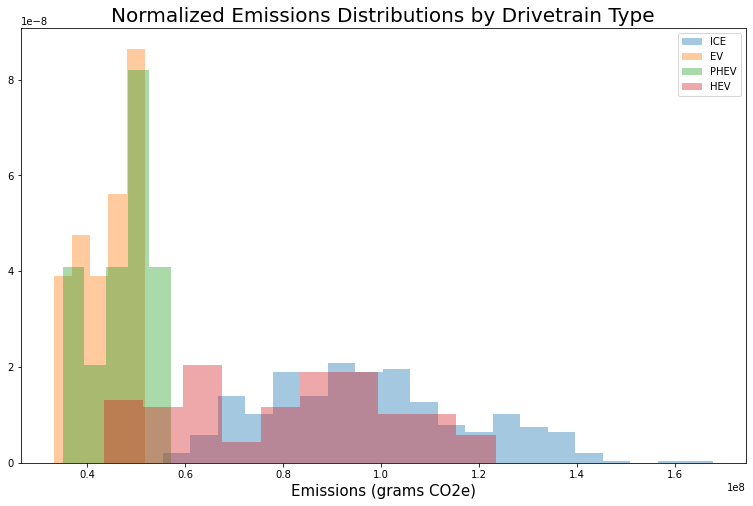

In [68]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (13,8))
plt.title('Normalized Emissions Distributions by Drivetrain Type', size = 20)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'ICE']['total'], density = True, label = 'ICE', bins = 20, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'EV']['total'],density = True, label = 'EV', bins = 5, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'PHEV']['total'],density = True, label = 'PHEV', bins = 5, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'HEV']['total'],density = True, label = 'HEV', bins = 10, alpha = 0.4)
plt.xlabel('Emissions (grams CO2e)', size = 15)
plt.legend()
plt.show()

In [149]:
## example visualization for tool output
## pick an ICE
Camry = emissionsjoin[emissionsjoin['Model_y'] == 'Camry']
## pick an EV of similar size
EQS450 = emissionsjoin[emissionsjoin['Model_y'] == 'EQS 450 4Matic']

Text(0, 0.5, 'Vehicle')

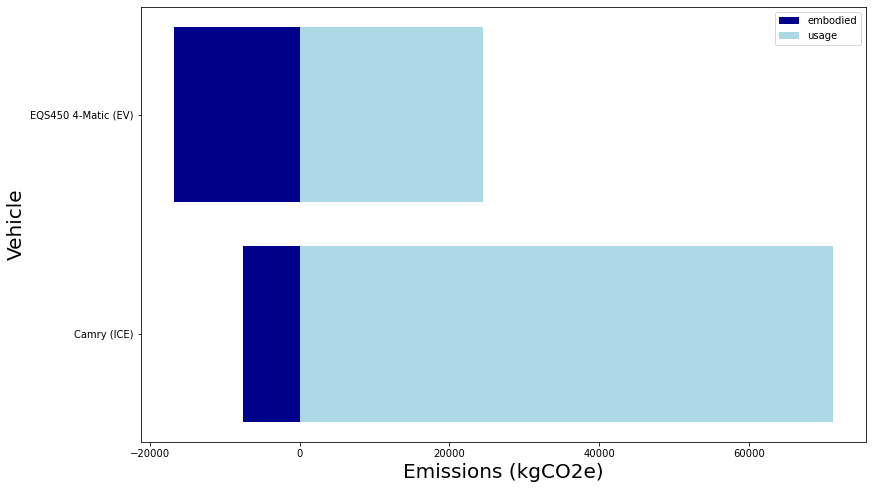

In [163]:
import matplotlib.pyplot as plt
x = ['Camry (ICE)', 'EQS450 4-Matic (EV)']
negative_data = [-1*Camry.total_embodied.iloc[0]/1000, -1*EQS450.total_embodied.iloc[0]/1000]
positive_data = [Camry.usage.iloc[0]/1000, EQS450.usage.iloc[0]/1000]

fig = plt.figure(figsize = (13,8))
ax = plt.subplot(111)
ax.barh(x, negative_data, color='darkblue', label = 'embodied')
ax.barh(x, positive_data, color='lightblue', label = 'usage')
plt.legend()
plt.xlabel('Emissions (kgCO2e)', size = 20)
plt.ylabel('Vehicle', size = 20)

In [349]:
#emissionsjoin.to_csv("emissions_vehicle_join_adjweights.csv", index = False)